In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../embo')
sys.path.append('../predinfo')
from embo.embo import empirical_bottleneck as eb

In [155]:
filename = "Data/RL_MDD_All.csv"
data_file = pd.read_csv(filename)


,Row Index,Subject,SubNum,Group,SubChoice,SubAction,RichFrac,Condition,RichFracChoice,Fractal1_Side,Fractal2_Side,Fractal_1_Rew,Fractal_2_Rew,TSCP,Reward
0,1,1210,1,MDD,2,2,1,Reward,0,1,2,1,0,1,0
1,2,1210,1,MDD,2,1,1,Reward,0,2,1,0,0,2,0
2,3,1210,1,MDD,1,1,1,Reward,1,1,2,1,0,3,1
3,4,1210,1,MDD,1,1,1,Reward,1,1,2,0,0,4,0
4,5,1210,1,MDD,2,2,1,Reward,0,1,2,0,0,5,0
5,6,1210,1,MDD,2,1,1,Reward,0,2,1,0,0,6,0
6,7,1210,1,MDD,1,2,1,Reward,1,2,1,0,0,7,0
7,8,1210,1,MDD,2,2,1,Reward,0,1,2,1,1,8,1
8,9,1210,1,MDD,2,2,1,Reward,0,1,2,1,0,9,0
9,10,1210,1,MDD,1,2,1,Reward,1,2,1,1,0,10,1


In [158]:
depressed = data_file.groupby(['Subject']).agg({'Group': lambda x: x.iloc[0]})
depressed

,Group
Subject,
1210,MDD
1211,MDD
1212,MDD
1213,MDD
1214,MDD
1215,MDD
1216,MDD
1217,MDD
1218,MDD


In [192]:
my_concat = lambda x: list(x.values)
agg_df = data_file.groupby(['Subject']).agg({
    'SubChoice':my_concat,
    'Reward' : my_concat,
    'RichFrac' : my_concat
}).reset_index()

In [38]:
agg_df

,Subject,Reward,SubChoice,RichFrac
0,1210,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ...","[2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1211,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1212,"[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1213,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,1214,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...","[2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,1215,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...","[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,1216,"[0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...","[1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,1217,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, ...","[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,1218,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...","[1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
9,1219,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [216]:
def trial_label(x):
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)

def make_features(trials_data):
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data

def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) 
                      for xi in np.unique(x)])/len(x)
    return px

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return joint_x_y

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi

def deltaBound(ib_ipast,ib_ifuture,p_ipast,p_ifuture):
    ''' Function to calculate distance from the bound between an empirical IB and participant predictive info
    ib_ipast: ipast of empirical IB (x of convex hull)
    ib_ifuture: ifuture of empirical IB (y of convex hull)
    p_ipast: participant ipast (uncorrected)
    p_ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ind = np.argwhere(np.array(ib_ipast) > p_ipast)[0][0]
    slp = (ib_ifuture[ind]-ib_ifuture[ind-1])/(ib_ipast[ind]-ib_ipast[ind-1])
    intercept = ib_ifuture[ind]-(slp*ib_ipast[ind])
    #Return distance between participant Ifuture and interpolated bound - higher 
    return p_ifuture - ((p_ipast*slp)+intercept)


# FUNCTIONS TO COMPUTE CONVEX HULL
def split(u, v, points):
    # return points on left side of UV
    return [p for p in points if np.cross(p - u, v - u) < 0]

def extend(u, v, points):
    if not points:
        return []

    # find furthest point W, and split search to WV, UW
    w = min(points, key=lambda p: np.cross(p - u, v - u))
    p1, p2 = split(w, v, points), split(u, w, points)
    return extend(w, v, p1) + [w] + extend(u, w, p2)

def convex_hull(points):
    # find two hull points, U, V, and split to left and right search
    u = min(points, key=lambda p: p[0])
    v = max(points, key=lambda p: p[0])
    left, right = split(u, v, points), split(v, u, points)

    # find convex hull on each side
    return [v] + extend(u, v, left) + [u] + extend(v, u, right) + [v]

[0.015541405478960683, 0.05279415763506657]

In [196]:
def mi_per_subject(subject_data):
#     trial_data = np.array([subject_data['Reward'].values, subject_data['SubChoice'].values])
    trial_data = np.array([[(subject_data['Reward'].values)[0]], 
                           [(subject_data['SubChoice'].values)[0]], 
                           [(subject_data['RichFrac'].values)[0]]])

    trial_data = trial_data.squeeze()
    features = make_features(trial_data)
    resp = trial_data[1,:]
    predInfo = [mutual_inf(features[:-1],resp[1:]),mutual_inf(features[1:],resp[:-1])]
    
    Fpast = features[:-1]
    Ffuture = features[1:]
    #  >>>>T HIS LINE TAKES A LONG TIME TO RUN   
    i_p,i_f,beta,mi,hx,hy = eb(Fpast,Ffuture,numbeta=3000,maxbeta=50)
    #  <<<<< THIS LINE TAKES A LONG TIME TO RUN 
    return (predInfo,i_p,i_f,mi)

In [198]:
sub_dict = {}
for subject in np.unique(agg_df['Subject']):
    print('Subject # %s' % subject)
    sub_dict[subject] = {}
    sub_dict[subject]['Subject'] = subject
    mi,i_p, i_f,saturation = mi_per_subject(agg_df[agg_df['Subject']==subject])
    
    sub_dict[subject]['Ipast'] = mi[0]
    sub_dict[subject]['Ifuture'] = mi[1]
    sub_dict[subject]['i_p'] = i_p
    sub_dict[subject]['i_f'] = i_f
    sub_dict[subject]['saturation'] = saturation

Subject # 1210
Subject # 1211
Subject # 1212
Subject # 1213
Subject # 1214
Subject # 1215
Subject # 1216
Subject # 1217
Subject # 1218
Subject # 1219
Subject # 1220
Subject # 1221
Subject # 1222
Subject # 1223
Subject # 1224
Subject # 1225
Subject # 1226
Subject # 1227
Subject # 1228
Subject # 1229
Subject # 1230
Subject # 1231
Subject # 1232
Subject # 1233
Subject # 1234
Subject # 1235
Subject # 1236
Subject # 1237
Subject # 1238
Subject # 1239
Subject # 1240
Subject # 1241
Subject # 1242
Subject # 1243
Subject # 1244
Subject # 1245
Subject # 1246
Subject # 1247
Subject # 1248
Subject # 1249
Subject # 1250
Subject # 1251
Subject # 1252
Subject # 1253
Subject # 1254
Subject # 1255
Subject # 1256
Subject # 1257
Subject # 1258
Subject # 1259
Subject # 1260
Subject # 1261
Subject # 1262
Subject # 1263
Subject # 1264
Subject # 1265
Subject # 1266
Subject # 1267
Subject # 1268
Subject # 1269
Subject # 1270
Subject # 1271
Subject # 1272
Subject # 1273
Subject # 1401
Subject # 1402
Subject # 

In [199]:
sub_to_mi_df = pd.DataFrame.from_dict(sub_dict, orient='index')

In [200]:
merged_df= sub_to_mi_df.join(depressed ,lsuffix='_caller', rsuffix='_other')
merged_df

,Subject,Ifuture,i_p,Ipast,saturation,i_f,Group
1210,1210,0.052794,"[1.0144463047367935e-10, 0.9220148156064449, 1...",0.047298,0.902672,"[9.201128747804432e-11, 0.7968234871103597, 0....",MDD
1211,1211,0.261090,"[1.4351364541198564e-10, 2.2329335279041125, 2...",0.457982,1.277341,"[1.212665523553369e-10, 1.2274757134805458, 1....",MDD
1212,1212,0.046290,"[3.318856300893458e-11, 1.4632992902998048, 2....",0.039991,1.019407,"[2.894129380592858e-11, 0.9113101291434078, 0....",MDD
1213,1213,0.012089,"[5.1308290949236834e-11, 0.9219970844491965, 1...",0.034447,0.914443,"[4.6835424427627004e-11, 0.8162184133662351, 0...",MDD
1214,1214,0.027169,"[6.300648891510718e-11, 1.251150752661078, 1.5...",0.037241,0.897060,"[5.688516324653392e-11, 0.8286423909134824, 0....",MDD
1215,1215,0.135307,"[9.081846386038706e-11, 1.951920900420927, 2.5...",0.581798,1.343299,"[7.236122812059875e-11, 1.2752982001959505, 1....",MDD
1216,1216,0.066240,"[4.2438941250111384e-11, 1.2449638962598606, 1...",0.072609,1.004556,"[3.786748692391484e-11, 0.8978125498065792, 0....",MDD
1217,1217,0.407147,"[1.4735812570165763e-10, 1.8397484026959448, 2...",0.505480,1.219448,"[1.290123563535417e-10, 1.156570865461879, 1.2...",MDD
1218,1218,0.028009,"[9.265255229706781e-11, 0.9220206174720038, 1....",0.037823,0.920444,"[8.424683173302583e-11, 0.7892539462505077, 0....",MDD
1219,1219,0.261312,"[4.9104720289960824e-11, 2.3492672650196837, 2...",0.328525,1.247899,"[3.2862157439694784e-11, 1.1940845910141218, 1...",MDD


In [184]:
merged_df.groupby(['Group']).mean()

,Subject,Ifuture,Ipast
Group,,,
Healthy Controls,1432.5,0.166082,0.317342
MDD,1241.5,0.121341,0.210126


In [185]:
merged_df.groupby(['Group']).var()

,Subject,Ifuture,Ipast
Group,,,
Healthy Controls,346.666667,0.022892,0.041834
MDD,346.666667,0.015269,0.046218


(array([12.,  6.,  6.,  7.,  7.,  3.,  5.,  3.,  0.,  3.,  0.,  1.,  3.,
         2.,  0.,  1.,  0.,  0.,  0.,  5.]),
 array([0.00516234, 0.03237687, 0.05959141, 0.08680594, 0.11402048,
        0.14123502, 0.16844955, 0.19566409, 0.22287862, 0.25009316,
        0.2773077 , 0.30452223, 0.33173677, 0.3589513 , 0.38616584,
        0.41338038, 0.44059491, 0.46780945, 0.49502398, 0.52223852,
        0.54945306]),
 <a list of 20 Patch objects>)

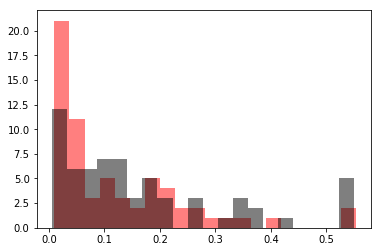

In [186]:
plt.figure()
plt.hist(merged_df[merged_df['Group']=='MDD']['Ifuture'], 20, facecolor='r', alpha=.5)

plt.hist(merged_df[merged_df['Group']=='Healthy Controls']['Ifuture'], 20, facecolor='k', alpha=.5)

In [187]:
high_past = merged_df[merged_df['Ifuture']>merged_df['Ipast']]

In [188]:
high_past.groupby(by=['Group']).count()

,Subject,Ifuture,Ipast
Group,,,
Healthy Controls,5,5,5
MDD,14,14,14


In [189]:
high_past

,Subject,Ifuture,Ipast,Group
1210,1210,0.052794,0.047298,MDD
1212,1212,0.046290,0.039991,MDD
1224,1224,0.080551,0.044817,MDD
1228,1228,0.019448,0.016063,MDD
1231,1231,0.028743,0.013710,MDD
1234,1234,0.246683,0.183975,MDD
1242,1242,0.025059,0.021952,MDD
1248,1248,0.043754,0.040733,MDD
1252,1252,0.034017,0.012930,MDD
1263,1263,0.173307,0.151018,MDD


In [225]:
def get_delta_subject(subject_data):
    i_p = subject_data['i_p'].values[0]
    i_f = subject_data['i_f'].values[0]
    
    points = np.stack([i_p,i_f],axis=1)
    hull = np.array(convex_hull(points))
    
    distance= deltaBound(np.flip(hull[0:-1,0],0),np.flip(hull[0:-1,1],0),
                         subject_data['Ipast'].values[0], subject_data['Ifuture'].values[0])
    return distance

distances = []
for subject in np.unique(merged_df['Subject']):
    
    s = merged_df[merged_df['Subject']==subject]
    distances.append(get_delta_subject(s))

In [210]:
s1['i_p'].values[0]

array([1.01444630e-10, 9.22014816e-01, 1.74481709e+00, 1.77023718e+00,
       1.77130078e+00, 1.99326874e+00, 2.17023844e+00, 2.20794679e+00])

In [226]:
distances

[0.011918290897651548,
 0.009330775198360342,
 0.02138465621941276,
 -0.018406438597189975,
 0.0025045066066845187,
 -0.24481401842550532,
 0.01387788127923769,
 0.08937298988992454,
 -0.0043677538242527895,
 0.09432947252542281,
 -0.006138622894934623,
 -0.0002171740172650094,
 -0.0014616640272168344,
 -0.06742303128360783,
 0.05096042029145095,
 -0.03582132928708921,
 -0.0024388788473959713,
 0.0031366841153950137,
 0.00573196363008213,
 -0.0963588557537233,
 0.10266744438435554,
 0.017115524375070475,
 0.04367664197213374,
 -0.015648218029275636,
 0.14722939201607205,
 -0.03313856399245782,
 -0.031169066401738575,
 0.13378292409445025,
 0.06531692686415266,
 -0.0014200978646748408,
 0.005808207450923891,
 0.005358900238369657,
 0.005709436693968145,
 0.021273291964088004,
 -0.03308942144949906,
 0.03136377851756844,
 0.0044443972110405836,
 -0.3765125308137025,
 0.016652969685893367,
 -0.026924607100730844,
 -0.034383167584791395,
 -0.10530775794450314,
 0.024937854743835808,
 0.089

## Plots to Make

### Distance From Bound, Healthy vs. MDD in different colors
#### mean distance from bound different?
#### correlation different?

### Normalizing Bounds by Saturation Point (divide both information vectors by that point)
#### repeat above, but also divide each subject's Ipast,Ifuture with the SP

